The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column card).

In [1]:
import pandas as pd

In [89]:
df = pd.read_csv('AER_credit_card_data.csv')
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [27]:
df.shape

(1319, 12)

Create the target variable by mapping yes to 1 and no to 0.

In [44]:
y = df['card'].apply(lambda x: 1 if x=='yes' else 0)

In [45]:
X = df.iloc[:, 1:]

Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1.

In [46]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score and compute AUC with the card variable.
Use the training dataset for that.
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* reports
* dependents
* active
* share

In [38]:
from sklearn.metrics import auc, roc_curve

for feature in ['reports', 'dependents', 'active', 'share']:    
    fpr, tpr, thresholds = roc_curve(y_train, X_train[feature], pos_label = 1)
    print('feature = {}, auc = {}'.format(feature, auc(fpr, tpr)))

feature = reports, auc = 0.28333701393106236
feature = dependents, auc = 0.46722427722262094
feature = active, auc = 0.6043173411362006
feature = share, auc = 0.989183643423692


In [39]:
df[['card', 'share']].head(20)
# An answer: "share"

,card,share
0,yes,0.033270
1,yes,0.005217
2,yes,0.004156
3,yes,0.065214
4,yes,0.067051
5,yes,0.044438
6,yes,0.012576
7,yes,0.076434
8,yes,0.245628
9,yes,0.019780


## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```


In [47]:
X_train = X_train.loc[:, ["reports", "age", "income", "share", "expenditure", "dependents", "months",\
                          "majorcards", "active", "owner", "selfemp"]]
X_val = X_val.loc[:, ["reports", "age", "income", "share", "expenditure", "dependents", "months",\
                      "majorcards", "active", "owner", "selfemp"]]
X_test = X_test.loc[:, ["reports", "age", "income", "share", "expenditure", "dependents", "months",\
                        "majorcards", "active", "owner", "selfemp"]]

In [41]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)

train_dict = X_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995

In [48]:
val_dict = X_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred, pos_label = 1)
print('auc = {}'.format(auc(fpr, tpr)))

auc = 0.995171242063847


An answer: 0.995

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* 0.3
* 0.6
* 0.8

In [51]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [55]:
thresholds = np.linspace(0, 1, 101)

In [57]:
scores = []

for threshold in thresholds:
    predict_positive = (y_pred >= threshold)
    predict_negative = (y_pred < threshold)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    scores.append((threshold, precision, recall))

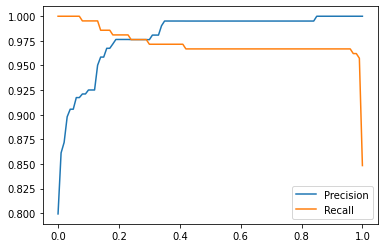

In [60]:
import matplotlib.pyplot as plt

columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()

In [62]:
df_scores['precision'].sort_values()

0      0.799242
1      0.861224
2      0.871901
3      0.897872
4      0.905579
         ...   
86     1.000000
85     1.000000
99     1.000000
90     1.000000
100    1.000000
Name: precision, Length: 101, dtype: float64

In [63]:
df_scores['recall'].sort_values()

100    0.848341
99     0.957346
97     0.962085
98     0.962085
53     0.966825
         ...   
4      1.000000
3      1.000000
2      1.000000
1      1.000000
0      1.000000
Name: recall, Length: 101, dtype: float64

An answer: 0.3

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing $F_1$:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7


In [66]:
df_scores['f1'] = 2 * df_scores['precision'] * df_scores['recall']/(df_scores['precision'] + df_scores['recall'])

In [68]:
df_scores[df_scores['f1'] == df_scores['f1'].max()]

,threshold,precision,recall,f1
35,0.35,0.995146,0.971564,0.983213
36,0.36,0.995146,0.971564,0.983213
37,0.37,0.995146,0.971564,0.983213
38,0.38,0.995146,0.971564,0.983213
39,0.39,0.995146,0.971564,0.983213
40,0.40,0.995146,0.971564,0.983213
41,0.41,0.995146,0.971564,0.983213


An answer: 0.4

## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24


I don't know exactly, what do you mean in `df_full_train` (there are no definition of this variable in "homework.md" before), so I will use this one:"df_full_train contains both train and val sets of our data". 

In [98]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [90]:
df['card'] = df['card'].apply(lambda x: 1 if x=='yes' else 0)
df['card'].unique()

array([1, 0], dtype=int64)

In [97]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['card'].values
    y_val = df_val['card'].values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print( '%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

1.000 +- 0.000


In [95]:
scores

# An answer: 0.003

[1.0, 1.0, 1.0, 1.0, 1.0]

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C


In [103]:
from tqdm.auto import tqdm

n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['card'].values
        y_val = df_val['card'].values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.993 +- 0.005
C=0.1 0.999 +- 0.001
C=1 1.000 +- 0.000
C=10 1.000 +- 0.000


An answer: 1 